In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/fedesoriano/heart-failure-prediction/versions/1


In [5]:
df = pd.read_csv('heart.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.shape


(918, 12)

In [6]:
df.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Stage: Cleanup and EDA

In [7]:
df.isnull().sum()

age               0
sex               0
chestpaintype     0
restingbp         0
cholesterol       0
fastingbs         0
restingecg        0
maxhr             0
exerciseangina    0
oldpeak           0
st_slope          0
heartdisease      0
dtype: int64

No NaN values seen!

See Distribution

In [8]:
print(df['heartdisease'].describe())


count    918.000000
mean       0.553377
std        0.497414
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: heartdisease, dtype: float64


Feature importnace

In [9]:
df.columns


Index(['age', 'sex', 'chestpaintype', 'restingbp', 'cholesterol', 'fastingbs',
       'restingecg', 'maxhr', 'exerciseangina', 'oldpeak', 'st_slope',
       'heartdisease'],
      dtype='object')

In [10]:
categorical_col = df.select_dtypes(include=['object']).columns
print(categorical_col)

Index(['sex', 'chestpaintype', 'restingecg', 'exerciseangina', 'st_slope'], dtype='object')


In [11]:
numerical_col = df.select_dtypes(exclude=['object']).columns
print(numerical_col)

Index(['age', 'restingbp', 'cholesterol', 'fastingbs', 'maxhr', 'oldpeak',
       'heartdisease'],
      dtype='object')


In [12]:

from sklearn.metrics import mutual_info_score
def mutual_info_heartissue_score(series):
    return mutual_info_score(series, df.heartdisease)
mi = df[categorical_col].apply(mutual_info_heartissue_score)
mi.sort_values(ascending=False).round(6)

st_slope          0.207474
chestpaintype     0.155988
exerciseangina    0.131680
sex               0.047477
restingecg        0.006045
dtype: float64

In [13]:
numerical_col = numerical_col.drop("heartdisease")
df[numerical_col].corrwith(df.heartdisease).abs().sort_values(ascending=False)


oldpeak        0.403951
maxhr          0.400421
age            0.282039
fastingbs      0.267291
cholesterol    0.232741
restingbp      0.107589
dtype: float64

Stage: Model Training 

Split data into train validation and test

In [14]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(550, 184, 184)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.heartdisease.values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

One-hot encoding

In [16]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE  # If using SMOTE for class imbalance

dv = DictVectorizer(sparse=False)




#train_dict = df_train[categorical_col + numerical_col].to_dict(orient='records')
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_val.to_dict(orient='records')
X_test = dv.transform(test_dict)
#dv.feature_names_

# # Step 1: Scale the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)

# # Step 2: Handle class imbalance
# smote = SMOTE()
# X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

Training logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
#model = LogisticRegression(solver='liblinear', C=1, max_iter=10, random_state=42)
#model = LogisticRegression(class_weight='balanced', penalty='l2', C=0.1, random_state=42, max_iter=1)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [18]:
y_val_probs = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_probs)
print(auc)



0.9089938300901756


In [19]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    # # Step 1: Scale the data
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # # Step 2: Handle class imbalance
    # smote = SMOTE()
    # X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    #X_scaled = scaler.transform(X)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
dv, model = train(df_train, y_train)
y_pred =  predict(df_val, dv, model)
roc_auc_score(y_val, y_pred)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.9089938300901756)

In [21]:
# from sklearn.model_selection import KFold
# #n_splits = [3, 5, 10, 15, 20, 100, 200, 250]
# n_splits = [15]
# for n_split in n_splits: 
#     kfold = KFold(n_splits=n_split, shuffle=True, random_state=1)
#     for train_idx, val_idx in kfold.split(df_full_train):
#         df_train = df_full_train.iloc[train_idx]
#         df_val = df_full_train.iloc[val_idx]

#         y_train = df_train.heartdisease.values
#         y_val = df_val.heartdisease.values

#         dv, model = train(df_train, y_train)
#         y_pred = predict(df_val, dv, model)
        

#     #print(accuracy_score(y_val, y_pred))
#     print(roc_auc_score(y_val, y_pred))

In [22]:
df['heartdisease'].describe()
count = (df['heartdisease'] == 1).sum()
print(count)

508


Training random forest regressor


In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.8913146654010442)

In [24]:
max_depth = 10
scores = []
auc_list = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))
        auc_list.append(auc)
print(max(auc_list))        

0.9108922638822972


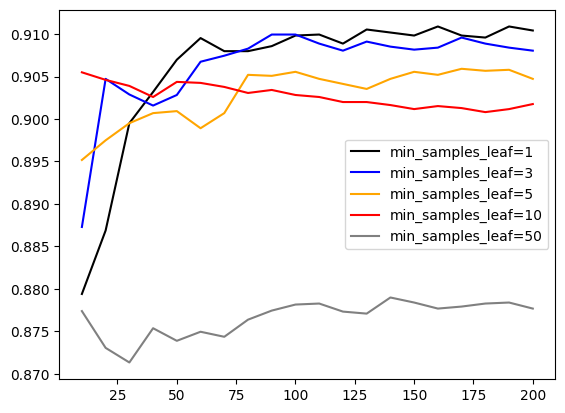

In [25]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [32]:
min_samples_leaf = 1

In [33]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=1)

In [34]:
y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(auc)

0.9104176554342667


XGBoost

In [35]:
import xgboost as xgb
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [43]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [44]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8970099667774085)

Try to tune few parameters

In [48]:
etas = [0.01, 0.3, 1]
max_depths = [1, 3, 6]
min_child_weights = [1, 10, 30]
scores = []
for eta in etas:
    for max_depth in max_depths:
        for min_child_weight in min_child_weights:
            xgb_params['eta'] = eta
            xgb_params['max_depth'] = max_depth
            xgb_params['min_child_weight']=min_child_weight
            model = xgb.train(xgb_params, dtrain, num_boost_round=10)
            y_pred = model.predict(dval)
            auc = roc_auc_score(y_val, y_pred)
            scores.append((eta, max_depth, min_child_weight, auc))
# Find the element with the maximum auc
max_auc_element = max(scores, key=lambda x: x[-1])

# Print the result
print("Element with maximum AUC:", max_auc_element)

Element with maximum AUC: (0.3, 3, 1, np.float64(0.9005695301376364))


Random forest model is giving slightly better results. 

Lets use it.